In [62]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

ImportError: No module named 'jupyterthemes'

In [63]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
#%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dimensionality Reduction

The starting point most data analysis problems is to perform some sort of exploratory data analysis on our raw data. This step is important because until we have basic understanding of the structure of our raw data, it might be hard to know whether the data is suitable for the task at hand or even derive insights that we can later share. During this exploratoy process, unsupervised methods such as dimensionality reduction can help us identify simpler and more compact representations of the original raw data to either aid our understanding or provide useful input to other stages of analysis. Here, we'll be focusing on a specific dimensionality reduction technique called **Principal Component Analysis (PCA)**.

Imagine that we're trying to understand some underlying phenomenon, in order to do so we measure various quantities potentially related to it. If we knew exactly what to measure in advance, we might be able to find some simple relationships in our data. But we typically don't, so we often measure anything that might be relevant and end up having irrelevant or redundant signals in our measurement. To make this a bit more concrete, we'll generate a toy 2-dimensional dataset to work with using the equation below.

$$x_2 = 500 + 20 \times x_1 + \epsilon$$

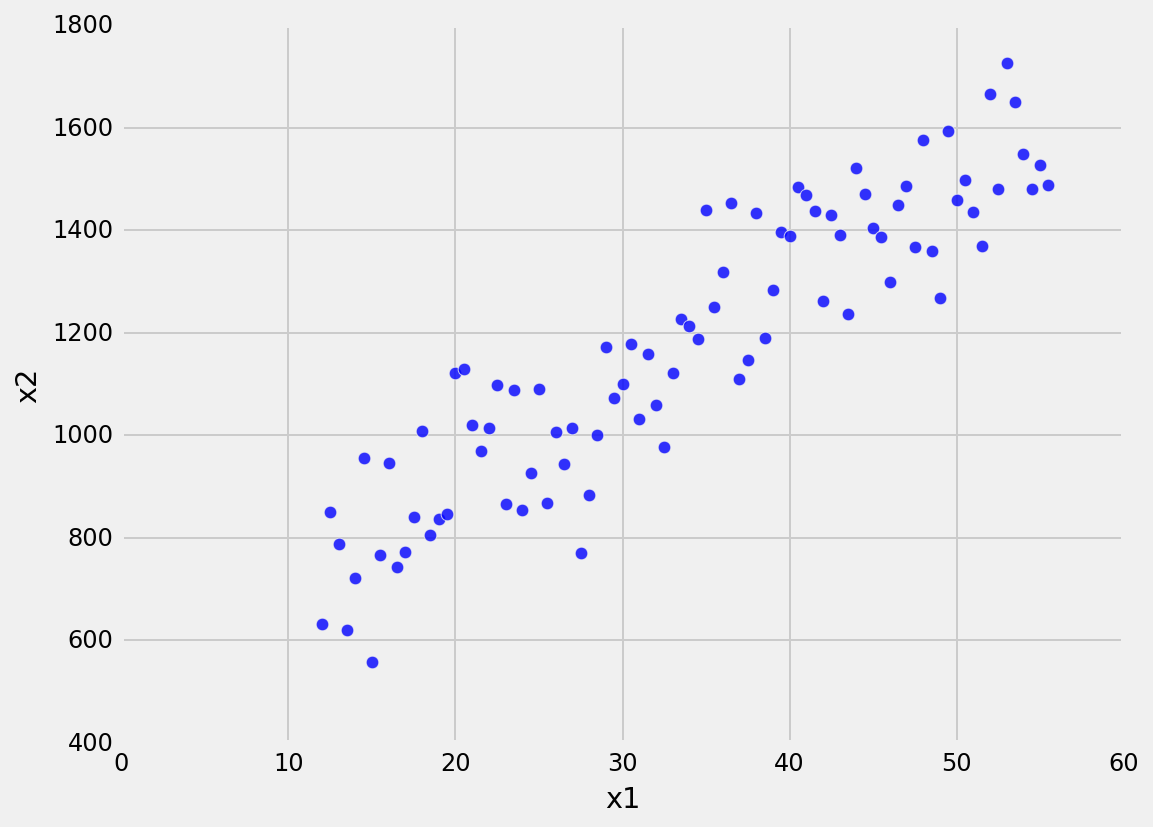

In [64]:
np.random.seed(123)
x1 = np.arange(12, 56, 0.5) # Generate even spaces from 12 to 56, with 0.5 space between
e  = np.random.normal(0, 100, x1.shape[0]) # Generate noise/error
x2 = 500 + 20 * x1 + e
X = np.c_[x1, x2] # Translates slice objects to concatenation along the second axis

# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

def plot2var(m):
    plt.scatter(m[:, 0], m[:, 1], s = 40, alpha = 0.8)
    plt.xlabel('x1')
    plt.ylabel('x2')

plot2var(X)

We can clearly see from the plot that there's linear relationship between the two variables, thus we probably don't need to include both of them as $x_1$ can be easily explained by $x_2$ and vice versa.

## PCA

If it is the case that one of the features is considered redundant, we should be able to summarize the data with less characteristics (features). So, the way PCA tackles this problem is: Instead of simply picking out the useful features and discarding the others, it uses a linear combination of the existing features and constructs some new features that are good alternative representation of the original data. In our 2D toy dataset, PCA will try to pick the best single direction, or often referred to as **first principal components** in 2D, and project our points onto that single direction. So the next question becomes, out of the many possible lines in 2D, what line should we pick?

It turns out, there are two different answers to this question. First answer is that we are looking for some features that strongly differ across data points, thus, PCA looks for features that captures as much variation across data points as possible. The second answer is that we are looking for the features that would allow us to "reconstruct" the original features. Imagine that we come up with a feature that has no relation to the original ones; If we were to use this new feature, there is no way we can relate this to the original ones. So PCA looks for features that minimizes the reconstruction error. These two notions can be depicted in the graph below, where the black dots represents the original data point, the black line represents the projected line, the red dot on the left shows the points on the projected line and the red line on the right shows the reconstruction error.
![alt text](objective1.png "Title")

<img src='img/objective1.png' width='80%'>

Surprisingly, it turns out that these two aims are equivalent and PCA can kill two birds with one stone. To see why minimizing squared residuals is equivalent to maximizing variance consider the 2 dimensions visualization below.
![alt text](objective2.png "Title")

<img src='img/objective2.png' width='80%'>

Consider a datapoint $a_i$. The contribution of this specific data point to the total variance is $a_i^Ta_i$, or equivalently the squared Euclidean length $\lVert \mathbf{a}_i \lVert^2$. Applying the Pythagorean theorem shows that this total variance equals the sum of variance lost (the squared residual) and variance remaining. Thus, it is equivalent to either maximize remaining variance or minimize lost variance to find the principal components.

Before we go another deeper, let's build some intuition using the scikit-learn library. The following section standardizes the data, fits the PCA model and prints out some of the important informations.

In [65]:
# we start by standardizing our dataset
# StandardScaler() class standardizes features by removing the mean and scaling to unit variance
# fit_transform is a combo of 
#               && fit: : used for generating learning model parameters from training data
#               && transform: parameters generated from fit() method applied 
#                             upon model to generate transformed data set.
X_std = StandardScaler().fit_transform(X) # n x 2 object


# call PCA specifying we only want the
# first two principal components (since
# we only have a 2d datset)
pca = PCA(n_components = 2)
pca.fit(X_std)

# important information
print('Components:\n ', pca.components_)
print('Explained Variance Ratio:\n ', pca.explained_variance_ratio_)

Components:
  [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
Explained Variance Ratio:
  [ 0.95588995  0.04411005]


After fitting the PCA on the dataset, the fit learns some quantities from the data, most importantly the "components", which is the principal components (the new direction that our data points will be projected upon) and "explained variance ratio", which corresponds to the percentage of variance explained by each of the principal components. To get a better sense of what these numbers mean, let's visualize them over our standardized input data.

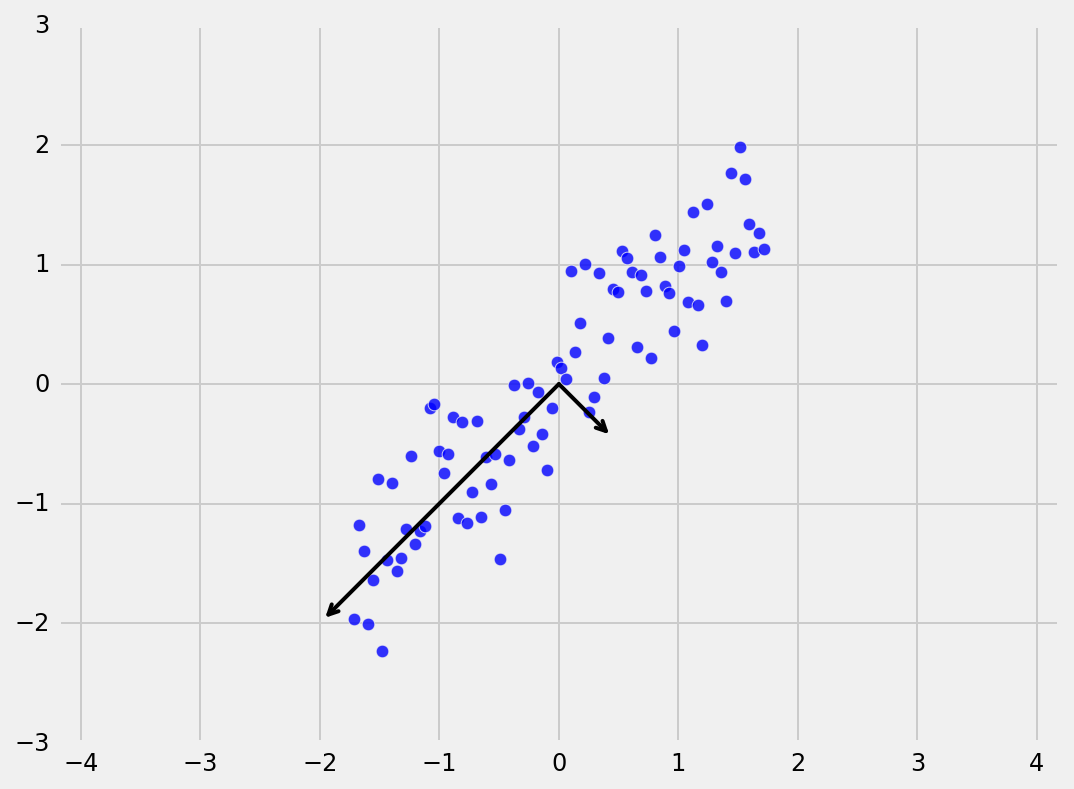

In [66]:
def draw_vector(v0, v1):
    """draw principal components as vectors"""
    ax = plt.gca()
    arrowprops = dict(arrowstyle = '->',
                      linewidth = 2, edgecolor = 'black',
                      shrinkA = 0, shrinkB = 0)
    plt.annotate('', v1, v0, arrowprops = arrowprops)

# plot data
plt.scatter(X_std[:, 0], X_std[:, 1], s = 40, alpha = 0.8)
for length, vector in zip(pca.explained_variance_, pca.components_):
    # the larger the explained variance, the longer the
    # annotated line will be
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)

plt.axis('equal')
plt.show()

From the plot, we see that our PCA model gives us two principal components (the black line) and the length of the lines indicate of how important that principal component is in describing the variation of the original data. So if we were to choose 1 principal component to summarize our 2d dataset, it will be line that has the longest length (largest explained variance ratio). There're two things worth noting:

- The number of principal components matches the total number of features
- The first and second principal components are orthogonal to each other

The reason for this is that principal components transform the data into a new set of dimensions, and these new dimensions have to be equal to the original amount of dimensions. And just like the original $x$, $y$ axis that we're used to, they have to be orthogonal to each other. Let's now reduce the dimension of our 2d dataset into 1d by transforming our data onto the most important principal component and plot it along with the original data.

original shape:    (88, 2)
transformed shape: (88, 1)


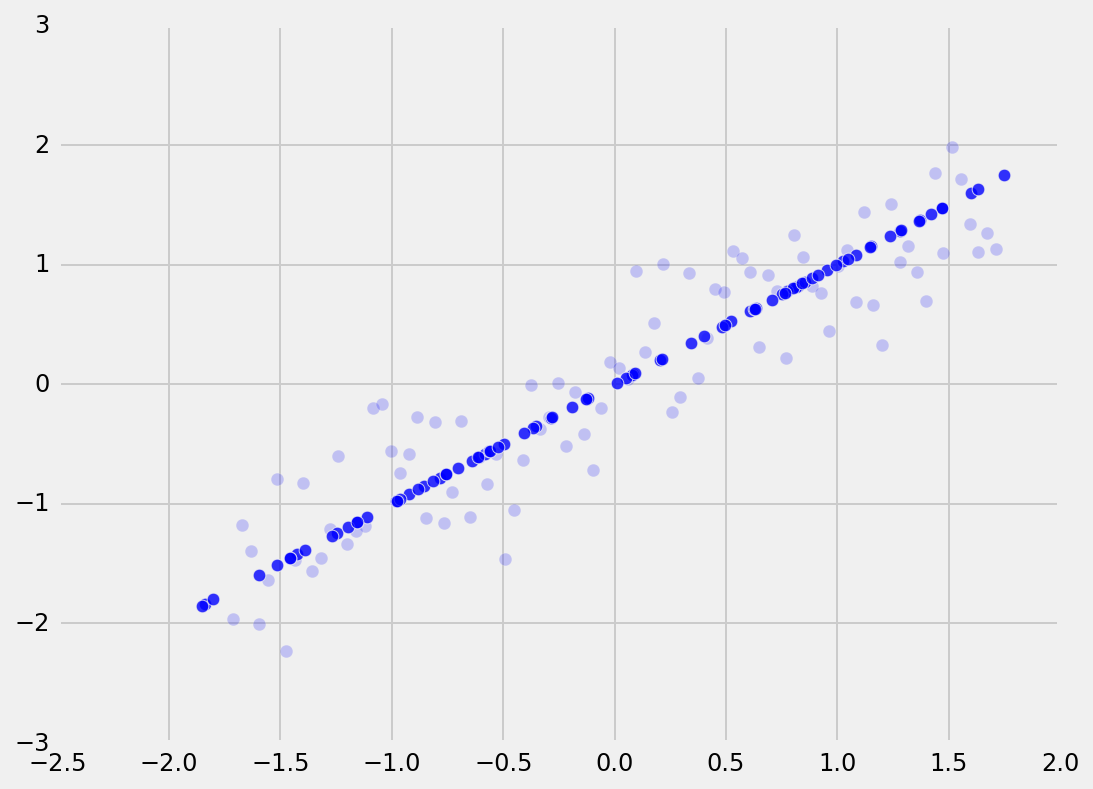

In [67]:
# dimensionality reduction, keeping only
# the first principal component
pca = PCA(n_components = 1)
X_pca = pca.fit_transform(X_std)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

# inverse transform to obtain the projected data
# and compare with the original
X_new = pca.inverse_transform(X_pca)
plt.scatter(X_std[:, 0], X_std[:, 1], s = 40, alpha = 0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], s = 40, alpha = 0.8)
plt.show()

In the plot above, the lighter points are the original data and the darker points are the projected version. Looking at the projections we see that the points projected onto the first principal component all seem close to their initial representations and at the same time, it also captures most of the variations in our original data points.

Hopefully, this elucidate what a PCA dimensionality reduction is doing. In a nutshell, PCA aims to find the directions or so called the principal components of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information. In our 2d example, the linear relationship between $x_1$ and $x_2$ is mostly preserved using only 1 feature instead of 2.

## PCA From Scratch

Now that we have a high level understanding of what PCA is accomplishing, let's now formalize this with some notations. Recall that PCA is trying the find the direction such that the projection of the data on it has the highest variance. So given $X$, the centered data matrix, the projection, $Xw$ (dot product between the data point, $X$ and the projection weight, $w$), its variance can be computed as follows:

\begin{align}
\frac{1}{n-1}(\mathbf{Xw})^\top \mathbf{Xw} = \mathbf w^\top (\frac{1}{n-1}\mathbf X^\top\mathbf X) \mathbf w = \mathbf w^\top \mathbf{Cw}
\end{align}

Where $\mathbf{C}$ is the covariance matrix of the data $\mathbf{X}$. In case this looks unfamiliar, the covariance matrix is a $d \times d$ matrix ($d$ is the total number of dimensions, features) where each element represents the covariance between two features. The covariance between two features $x_j$ and $x_k$ is calculated as follows:

\begin{align}
\sigma_{jk} = \frac{1}{n-1} \sum_{i=1}^{n} \left( x_{ij} - \bar{x}_j \right) \left( x_{ik} - \bar{x}_k \right)
\end{align}

Where $\bar{x}_j$ is simply the mean of vector (feature) $\bar{x}_j = \sum \limits_{i=1}^n x_{ij}$.

We can also express the calculation of the covariance matrix via the following matrix equation: 

\begin{align}
\mathbf{C} = \frac{1}{n-1} \big( (X - \bar{x})^\top( X - \bar{x}) \big)
\end{align}

Because we already assume to data point $X$ has been centered, thus the $X - \bar{x}$ part can be simplified into just $X$. And the formula above simply becomes:

\begin{align}
\mathbf{C} = \frac{1}{n-1} X^\top X
\end{align}

Next, apart from the original objective function $\mathbf w^\top \mathbf{Cw}$, we also introduce an additional constraint $\|\mathbf w\|=\mathbf w^\top \mathbf w=1$, saying our weight vector should have unit length. The intuition behind this is that: If we were to simply maximize the formula $\mathbf w^\top \mathbf{Cw}$, we can multiply $w$ by any number and the objective function will increase by the square of this number. So the problem becomes ill-defined since the maximum of this expression is infinite. Given these two pieces of information, our objective function for PCA becomes:

\begin{align}
&  \underset{\mathbf{w}}{\text{maximize}}
&& \mathbf w^\top \mathbf{Cw} \nonumber \\
&  \text{subject to}
&& \mathbf w^\top \mathbf w=1
\end{align}

This objective function can be solved by the Lagrange multiplier, minimizing the loss function:

\begin{align}
L &= \mathbf w^\top \mathbf{Cw}-\lambda(\mathbf w^\top \mathbf w-1)
\end{align}

If this looks unfamiliar, check out the following tutorial on Lagrange multiplier. [Khan Academy: Lagrange multipliers, examples](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-examples). Next, to solve for $w$, we set the partial derivative of $L$ with respect to $w$ to 0.

\begin{align}
\frac{\partial L}{\partial \mathbf w} 
& \implies \mathbf{Cw} - \lambda \mathbf w = 0 \\
& \implies \mathbf{Cw} = \lambda \mathbf w
\end{align}

Hopefully the formula above looks familar, since it's essentially an eigendecomposition problem. The notion of eigendecomposition is basically trying to solve the equation:

\begin{align}
Ax &= \lambda x
\end{align}

In our case, $A$ is our covariance matrix correponding to $\mathbf C$; $x$ is our eigenvector, correponding to $\mathbf w$ and $\lambda$ is our eigenvalue correponding to explained variance. After solving the equation above, we'll obtain eigenvector and eigenvalue pairs, where very eigenvector has a corresponding eigenvalue. An eigenvector is essentially the direction of each principal component and the eigenvalue is a number, telling us how much variance there is in the data in that direction, in other words, how spread out the data is on the line. For those interested, the following blog walks through the calculating eigenvalue and eigenvectors from scratch. [Blog: What are eigenvectors and eigenvalues?](http://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/)

Given all of that, let's see how this works in code. Just to summarize, the general framework for computing PCA is as follows:

- Standardize the data
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix
- Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace
- Projection onto the new feature space. During this step we will take the top $k$ eigenvectors and use it to transform the original dataset $X$ to obtain a k-dimensional feature subspace $X'$

For the section below, we will be working with the famous "Iris" dataset. The iris dataset is a 150×4 matrix where the columns are the different features (sepal length in cm, sepal width in cm, petal length in cm, petal width in cm) and every every row represents a separate flower sample. The three classes in the Iris dataset are: Iris-setosa (n=50), Iris-versicolor (n=50), Iris-virginica (n=50). We'll use histograms to get a feeling of how the 3 different flower classes are distributes along the 4 different features.

In [68]:
import pandas

filename = 'IMDB-Movie-Data.csv'
features = ['Rank','Title','Genre','Description','Director','Actors','Year','Runtime (Minutes)', 
            'Rating','Votes','Revenue (Millions)']

###,'Metascore']
data = pandas.read_csv(filename)#, names = features)
target = ['Metascore']

# Select only numeric columns - Integers and floats as this would simplify the data handling
data = data.select_dtypes(include=['int64','float'])

# Replace every NaN values with 0
data.fillna(value=0,axis=1,inplace=True)


print(data.shape)
#print(data)

features_numeric =  ['Rank','Year','Runtime (Minutes)', 
            'Rating','Votes','Revenue (Millions)']
X = data[features_numeric]
y = data[target]


(1000, 7)


In [34]:
'''iris = load_iris()
X = iris['data']
y = iris['target']

label_dict = {0: 'Iris-Setosa',
              1: 'Iris-Versicolor',
              2: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

fig = plt.figure(figsize = (10, 6))
for feature in range(len(feature_dict)):
    plt.subplot(2, 2, feature + 1)
    for index, label in label_dict.items():
        plt.hist(X[y == index, feature], label = label,
                 bins = 10, alpha = 0.3)
        plt.xlabel(feature_dict[feature])
        
plt.legend(loc = 'upper right', fancybox = True, fontsize = 12)
plt.tight_layout()
plt.show()
'''


"iris = load_iris()\nX = iris['data']\ny = iris['target']\n\nlabel_dict = {0: 'Iris-Setosa',\n              1: 'Iris-Versicolor',\n              2: 'Iris-Virgnica'}\n\nfeature_dict = {0: 'sepal length [cm]',\n                1: 'sepal width [cm]',\n                2: 'petal length [cm]',\n                3: 'petal width [cm]'}\n\nfig = plt.figure(figsize = (10, 6))\nfor feature in range(len(feature_dict)):\n    plt.subplot(2, 2, feature + 1)\n    for index, label in label_dict.items():\n        plt.hist(X[y == index, feature], label = label,\n                 bins = 10, alpha = 0.3)\n        plt.xlabel(feature_dict[feature])\n        \nplt.legend(loc = 'upper right', fancybox = True, fontsize = 12)\nplt.tight_layout()\nplt.show()\n"

### Standardize

In general, it's important to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially if it was measured on different scales so different features will have equal contribution in terms of their scales.

In [69]:
# subtract the mean and divide the
# standard deviation of each features
mean = np.mean(X, axis = 0)
print(mean.shape)

scale = np.std(X, axis = 0)
print(scale.shape)

X_std = (X - mean) / scale
print(X_std.shape)

(6,)
(6,)
(1000, 6)


### Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance matrix is the core of PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude (variance explained along the principal components).

In [70]:
# for those unfamiliar with the @ syntax it
# is equivalent of .dot, the dot product
vec_mean = np.mean(X_std, axis = 0)
vec_diff = X_std - vec_mean

print(type(vec_mean))
print(type(X_std.shape[0]))

#cov_mat  = vec_diff.T @ vec_diff / (X_std.shape[0] - 1)
cov_mat  = np.dot(vec_diff.T,vec_diff / (X_std.shape[0] - 1)) # Use of NumPy library

print('Covariance matrix \n {}'.format(cov_mat))

# note that since we already standardized the data,
# meaning the mean vector for each features, vec_mean 
# will be 0 (really small numbers if you were to print them out),
# hence we don't have to substract the mean to standardize them
cov_mat = np.dot(X_std.T,X_std / (X_std.shape[0] - 1)) # Use of NumPy library
print('Covariance matrix \n {}'.format(cov_mat))

# equivalently, we could have used the np.cov function:
# since each row represents a variable for np.cov,
# we'll need to transpose the matrix
print('NumPy covariance matrix: \n {}'.format(np.cov(X_std.T)))

<class 'pandas.core.series.Series'>
<class 'int'>
Covariance matrix 
 [[ 1.001001   -0.26186703 -0.22196124 -0.21977498 -0.28416019 -0.26280783]
 [-0.26186703  1.001001   -0.16506487 -0.21143019 -0.41231614 -0.18178375]
 [-0.22196124 -0.16506487  1.001001    0.39260685  0.40746921  0.30030461]
 [-0.21977498 -0.21143019  0.39260685  1.001001    0.51204937  0.25197305]
 [-0.28416019 -0.41231614  0.40746921  0.51204937  1.001001    0.66584133]
 [-0.26280783 -0.18178375  0.30030461  0.25197305  0.66584133  1.001001  ]]
Covariance matrix 
 [[ 1.001001   -0.26186703 -0.22196124 -0.21977498 -0.28416019 -0.26280783]
 [-0.26186703  1.001001   -0.16506487 -0.21143019 -0.41231614 -0.18178375]
 [-0.22196124 -0.16506487  1.001001    0.39260685  0.40746921  0.30030461]
 [-0.21977498 -0.21143019  0.39260685  1.001001    0.51204937  0.25197305]
 [-0.28416019 -0.41231614  0.40746921  0.51204937  1.001001    0.66584133]
 [-0.26280783 -0.18178375  0.30030461  0.25197305  0.66584133  1.001001  ]]
NumPy co

After obtaining the covariance matrix, we perform an eigendecomposition on it to obtain the eigenvalues and eigenvectors.

In [71]:
# since computing this by hand can be quite tedious
# we'll simply use the pre-implemented function
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' % eig_vecs)
print('\nEigenvalues \n%s' % eig_vals)

Eigenvectors 
[[-0.25328006  0.69463719  0.15887324 -0.6261548   0.17812879 -0.06548263]
 [-0.25915764 -0.70772768  0.29437762 -0.58269442  0.06848615 -0.03282575]
 [ 0.40521367 -0.07139879  0.00179283  0.02465733  0.74895567 -0.51880469]
 [ 0.42957808 -0.00183903 -0.23825262 -0.34855051 -0.59170564 -0.53580962]
 [ 0.55695788  0.08905989  0.77997331  0.00944185 -0.13055157  0.23743427]
 [ 0.45798362 -0.05973167 -0.47220252 -0.38237781  0.18837705  0.61806893]]

Eigenvalues 
[ 2.56099095  1.27736564  0.22892249  0.48750649  0.62744714  0.8237733 ]


### Choosing Top K Eigenvectors

Recall that the typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace. In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues. The idea is: eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data and those are the ones can be dropped. In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called “explained variance,” which can be calculated from the eigenvalues. The explained variance tells us how much extra information (variance) does each of the principal components contribute.

Variance Explained:  [ 0.42640499  0.21268138  0.03811559  0.08116983  0.10446995  0.13715825]
Cumulative Variance Explained:  [ 0.42640499  0.63908637  0.67720197  0.7583718   0.86284175  1.        ]


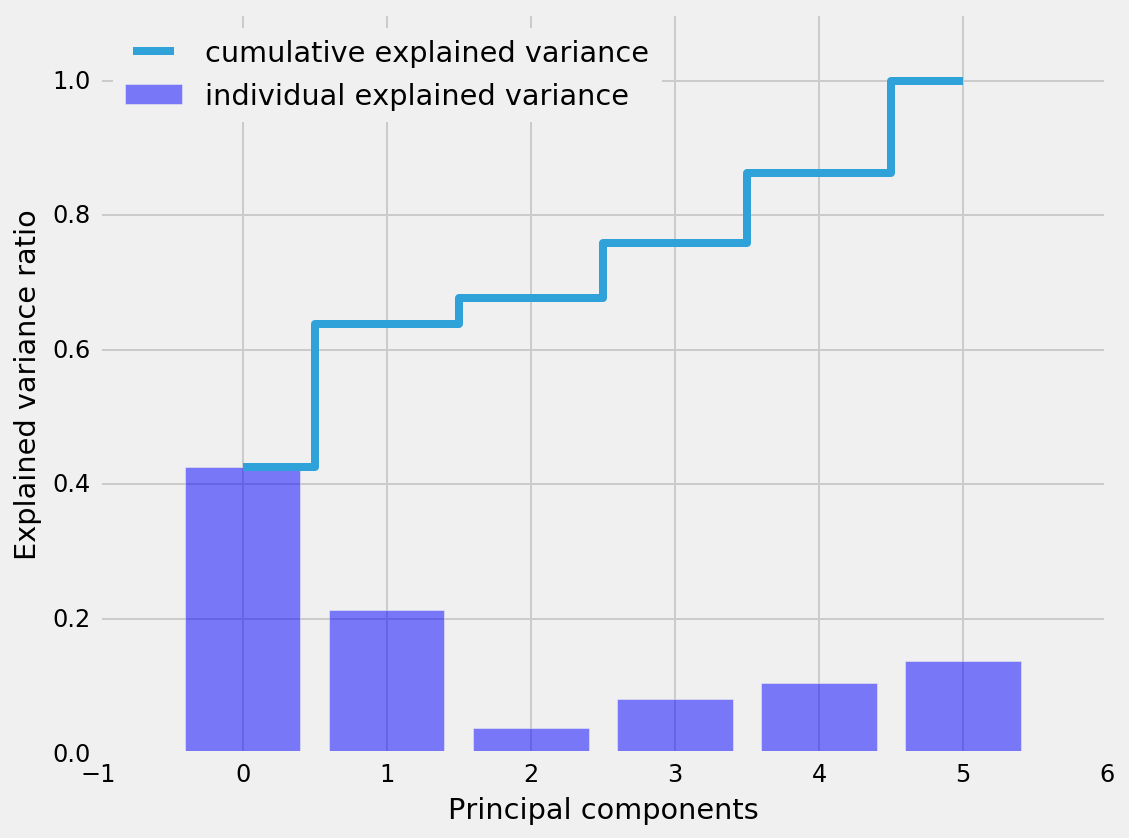

In [72]:
eig_vals_total = np.sum(eig_vals)
var_exp = eig_vals / eig_vals_total
cum_var_exp = np.cumsum(var_exp)
print('Variance Explained: ', var_exp)
print('Cumulative Variance Explained: ', cum_var_exp)

plt.bar(range(var_exp.shape[0]), var_exp, alpha = 0.5, 
        align = 'center', label = 'individual explained variance')
plt.step(range(var_exp.shape[0]), cum_var_exp, 
         where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.tight_layout()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components explains 95.8% of the variance. Or in other words, it contain 95.8% of the information (95% or 99% are comon threshold that people use).

### Projection Onto the New Feature Space

In the last step, we will use the 4×2-dimensional eigenvectors to transform our samples onto the new subspace via the equation $Y=XW$, where Y will be our 150×2 matrix of transformed samples (we reduce the dimension from the original 4 down to 2).

In [59]:
def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate( zip(target, markers) ):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

In [75]:
X_std_pca = X_std.dot(eig_vecs[:, 0:2])
#plot_iris_pca(X_std_pca, y)

We'll put all of this into a single class, train it and confirm the result with scikit-learn's PCA model by printing out the explained variance ratio.

In [76]:
class PCAModel:
    """
    Principal component analysis (PCA)
    
    Parameters
    ----------
    n_components : int
        top number of principal components to keep
    """

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # standardize
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X = (X - self.mean) / self.scale
        
        # eigendecomposition
        eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T))
        self.components = eig_vecs[:, :self.n_components]
        var_exp = eig_vals / np.sum(eig_vals)
        self.explained_variance_ratio = var_exp[:self.n_components]
        return self

    def transform(self, X):
        X = X.copy()
        X = (X - self.mean) / self.scale
        X_pca = X @ self.components
        return X_pca

In [77]:
# implementation from scratch
pca_model = PCAModel(n_components = 2).fit(X)

# using library to confirm results
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components = 2).fit(X_std)

# print explained ratio to see if the matches
print('library: ', pca.explained_variance_ratio_)
print('from scratch: ', pca_model.explained_variance_ratio)

library:  [ 0.42640499  0.21268138]
from scratch:  [ 0.42640499  0.21268138]


## Takeaway

Let's wrap this up with a summary of PCA and some of its applications. In order to identify patterns in our data, we often look for variation across observations to distinguish them from one another. Hence it seems reasonable to be able to find a succinct representation that best captures the variation in our initial data. PCA, in particular, look to explain our data via its maximum directions of variance. By compressing a higher dimensional dataset into lower one, while still retaining most of the variance this allows us to:

- Perform Visualization: PCA summarizes our data along the principal components (or eigenvectors), which explains most the variance. Thus we can reduce the dataset to 2 or 3 dimensions and visualize our data's distribution. This can be helpful when we're performing clustering algorithm that needs to choose the cluster number beforehand.
- Speed up machine learning algorithms: When dealing with Big Data, we might want to decompose the features into a lower dimension, without a significant loss in variance. By performing dimensionality reduction methods, we can reduce the amount of features we have to speed up the training algorithm and save memory. For this part, we'll use the Iris dataset again and show that by keeping the data's top 3 principal components we can obtain the same level of accuracy as keeping all 4 features.

In [78]:
# split 30% of the iris data into a test set for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 1)

# create the pipeline, where we'll
# standardize the data, perform PCA and
# fit the logistic regression
pipe1 = Pipeline([
    ('standardize', StandardScaler()),
    ('pca', PCA(n_components = 3)),
    ('logistic', LogisticRegression(random_state = 1))
])
pipe1.fit(X_train, y_train)
y_pred1 = pipe1.predict(X_test)

# pipeline without PCA
pipe2 = Pipeline([
    ('standardize', StandardScaler()),
    ('logistic', LogisticRegression(random_state = 1))
])
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)

# access the prediction accuracy
print('PCA Accuracy %.3f' % accuracy_score(y_test, y_pred1))
print('Accuracy %.3f' % accuracy_score(y_test, y_pred2))

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA Accuracy 0.057
Accuracy 0.057


# Reference

- [Youtube: Dimensionality Reduction](https://www.youtube.com/playlist?list=PLnnr1O8OWc6aVexn2BY0qjklobY6TUEIy)
- [Blog: What are eigenvectors and eigenvalues?](http://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/)
- [Blog: Principal Component Analysis 4 Dummies](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/)
- [Blog: Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)
- [Blog: Principal Component Analysis in 3 Simple Steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)
- [Notebook: In Depth: Principal Component Analysis](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/95664b978439df948b2cd2f5f5b4e31f28b30394/notebooks/05.09-Principal-Component-Analysis.ipynb)
- [StackExchange: Making sense of principal component analysis, eigenvectors & eigenvalues](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
- [StackExchange: What is an intuitive explanation for how PCA turns from a geometric problem (with distances) to a linear algebra problem (with eigenvectors)?](http://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit)